     ┌───┐           ░ ┌─┐      
q_0: ┤ H ├──■────■───░─┤M├──────
     └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
q_1: ─────┤ X ├──┼───░──╫─┤M├───
          └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
q_2: ──────────┤ X ├─░──╫──╫─┤M├
               └───┘ ░  ║  ║ └╥┘
c: 3/═══════════════════╩══╩══╩═
                        0  1  2 

Noisy Counts: {'000': 480, '111': 521, '011': 4, '110': 2, '010': 5, '001': 4, '101': 7, '100': 1}


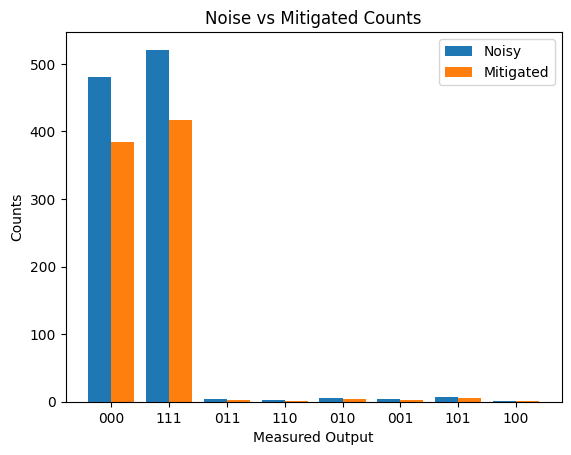

In [3]:
# tackle noise with error correction
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Step 1: Create Encoding Circuit (3-qubit bit-flip code)
circuit = QuantumCircuit(3, 3)

# Encode |+> using H and CNOTs (bit-flip code)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 2)

circuit.barrier()

# Step 2: Add Measurement (to detect flips)
circuit.measure([0, 1, 2], [0, 1, 2])

print(circuit.draw())

# Step 3: Add Noise Model
noise = NoiseModel()

# Single qubit depolarizing noise
d1 = depolarizing_error(0.01, 1)
# Two qubit depolarizing noise for CNOTs
d2 = depolarizing_error(0.02, 2)

noise.add_all_qubit_quantum_error(d1, ["h", "x"])
noise.add_all_qubit_quantum_error(d2, ["cx"])

# Step 4: Run with Noise
backend = AerSimulator()
compiled = transpile(circuit, backend)
result = backend.run(compiled, shots=1024, noise_model=noise).result()
noisy_counts = result.get_counts()

print("\nNoisy Counts:", noisy_counts)

# Step 5: Simple Error Mitigation (scaling technique)
mitigated_counts = {key: noisy_counts[key] * 0.8 for key in noisy_counts}  # 20% noise removed

# Step 6: Plot Result
labels = list(noisy_counts.keys())
x = range(len(labels))

plt.bar(x, [noisy_counts[k] for k in labels], width=0.4, label="Noisy")
plt.bar([i + 0.4 for i in x], [mitigated_counts[k] for k in labels], width=0.4, label="Mitigated")

plt.xticks([i + 0.2 for i in x], labels)
plt.xlabel("Measured Output")
plt.ylabel("Counts")
plt.title("Noise vs Mitigated Counts")
plt.legend()
plt.show()


3-bit repetition code decoding accuracy vs bit-flip probability p:
 p = 0.00 -> accuracy = 1.0000
 p = 0.05 -> accuracy = 0.9922
 p = 0.10 -> accuracy = 0.9696
 p = 0.15 -> accuracy = 0.9364
 p = 0.20 -> accuracy = 0.8982
 p = 0.25 -> accuracy = 0.8434
 p = 0.30 -> accuracy = 0.7844
 p = 0.35 -> accuracy = 0.7254
 p = 0.40 -> accuracy = 0.6556
 p = 0.45 -> accuracy = 0.5862
 p = 0.50 -> accuracy = 0.4980


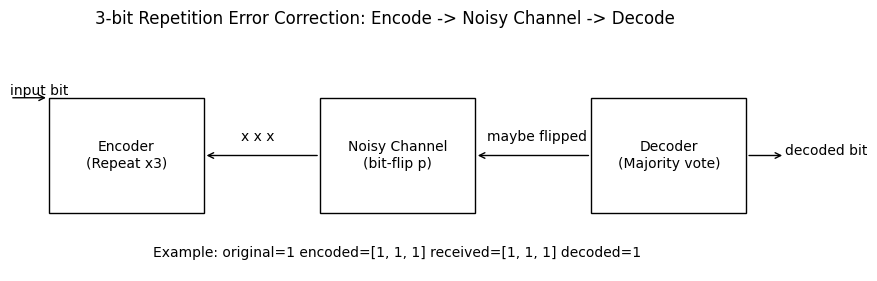

In [5]:
# Simple demonstration of tackling noise with a 3-bit repetition error-correcting code
# This code encodes a single bit using repetition (000 or 111), sends through a noisy channel
# that flips bits with probability p, decodes with a majority vote, and reports accuracy.
# It also draws a simple circuit-style diagram (encoding -> noisy channel -> decoding).
import random
import numpy as np
import matplotlib.pyplot as plt

def encode(bit):
    "3-bit repetition encoding"
    return [bit, bit, bit]

def transmit(encoded_bits, p_flip):
    "Simulate independent bit flips with probability p_flip"
    return [b ^ (random.random() < p_flip) for b in encoded_bits]

def decode(received):
    "Majority-vote decoding for 3-bit repetition code"
    return 1 if sum(received) >= 2 else 0

def simulate(p_flip, trials=1000):
    successes = 0
    for _ in range(trials):
        original = random.choice([0,1])
        enc = encode(original)
        received = transmit(enc, p_flip)
        dec = decode(received)
        if dec == original:
            successes += 1
    return successes / trials

# Run a small sweep of noise probabilities and print accuracy
ps = np.linspace(0.0, 0.5, 11)
accuracies = [simulate(p, trials=5000) for p in ps]

print("3-bit repetition code decoding accuracy vs bit-flip probability p:")
for p, acc in zip(ps, accuracies):
    print(f" p = {p:.2f} -> accuracy = {acc:.4f}")

# Draw a simple circuit diagram showing encode -> noisy channel -> decode
fig, ax = plt.subplots(figsize=(10,3))
ax.axis('off')

# Boxes for components
ax.add_patch(plt.Rectangle((0.05, 0.25), 0.2, 0.5, fill=False))
ax.text(0.15, 0.5, "Encoder\n(Repeat x3)", ha='center', va='center')

ax.add_patch(plt.Rectangle((0.4, 0.25), 0.2, 0.5, fill=False))
ax.text(0.5, 0.5, "Noisy Channel\n(bit-flip p)", ha='center', va='center')

ax.add_patch(plt.Rectangle((0.75, 0.25), 0.2, 0.5, fill=False))
ax.text(0.85, 0.5, "Decoder\n(Majority vote)", ha='center', va='center')

# Arrows and signals
# Input bit arrow
ax.annotate("", xy=(0.05, 0.75), xytext=(0.0, 0.75), arrowprops=dict(arrowstyle="->"))
ax.text(0.0, 0.78, "input bit", ha='left', va='center')

# Between Encoder and Channel
ax.annotate("", xy=(0.25, 0.5), xytext=(0.4, 0.5), arrowprops=dict(arrowstyle="->"))
ax.text(0.32, 0.58, "x x x", ha='center', va='center')

# Between Channel and Decoder (show possible flip)
ax.annotate("", xy=(0.6, 0.5), xytext=(0.75, 0.5), arrowprops=dict(arrowstyle="->"))
ax.text(0.68, 0.58, "maybe flipped", ha='center', va='center')

# Output
ax.annotate("", xy=(1.0, 0.5), xytext=(0.95, 0.5), arrowprops=dict(arrowstyle="->"))
ax.text(1.0, 0.52, "decoded bit", ha='left', va='center')

# Under diagram: short example of one encoded->noisy->decoded path
orig = 1
enc = encode(orig)
rec = transmit(enc, p_flip=0.2)
dec = decode(rec)
example_text = f"Example: original={orig} encoded={enc} received={rec} decoded={dec}"
ax.text(0.5, 0.08, example_text, ha='center', va='center')

plt.suptitle("3-bit Repetition Error Correction: Encode -> Noisy Channel -> Decode")
plt.show()
